In [1]:
#Task 1
import numpy as np
import pandas as pd
import tensorflow_decision_forests as tfdf
from sklearn.model_selection import KFold

print("TF-DF:", tfdf.__version__)


train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df  = pd.read_csv("/kaggle/input/titanic/test.csv")


def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    def normalize_name(x: str) -> str:
        return " ".join([v.strip(",()[].\"'") for v in x.split(" ")])
    def ticket_number(x: str) -> str:
        return x.split(" ")[-1]
    def ticket_item(x: str) -> str:
        items = x.split(" ")
        return "NONE" if len(items) == 1 else "_".join(items[:-1])

    df["Name"] = df["Name"].apply(normalize_name)
    df["Ticket_number"] = df["Ticket"].apply(ticket_number)
    df["Ticket_item"] = df["Ticket"].apply(ticket_item)

    df["Age"] = df["Age"].fillna(df["Age"].median())
    df["Fare"] = df["Fare"].fillna(df["Fare"].median())
    if "Embarked" in df.columns:
        df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

    if {"SibSp","Parch"}.issubset(df.columns):
        df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
        df["IsAlone"] = (df["FamilySize"] == 1).astype(int)

    return df

train_df = preprocess(train_df)
test_df  = preprocess(test_df)

train_df["Survived"] = train_df["Survived"].astype("category")


ignore = ["PassengerId", "Ticket", "Name", "Ticket_number"]
feature_cols = [c for c in train_df.columns if c not in ignore + ["Survived"]]
print("Features:", feature_cols)

train_ds_full = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label="Survived")

def keras_eval_accuracy(model, df):
    """Robust accuracy on a pandas fold (works across TF-DF versions)."""
    y_true = df["Survived"].astype("category").cat.codes.to_numpy()

    ds = tfdf.keras.pd_dataframe_to_tf_dataset(df, label="Survived")
    preds = model.predict(ds, verbose=0)

    preds = np.asarray(preds)
    if preds.ndim == 2 and preds.shape[1] == 1:
        y_pred = (preds.ravel() >= 0.5).astype(int)
    elif preds.ndim == 2:
        y_pred = np.argmax(preds, axis=1)
    else:
        y_pred = (preds >= 0.5).astype(int)

    return (y_pred == y_true).mean()


# Decision Tree
dt_model = tfdf.keras.CartModel(task=tfdf.keras.Task.CLASSIFICATION, random_seed=42)
dt_model.fit(train_ds_full)
dt_full_acc = keras_eval_accuracy(dt_model, train_df)
print(f"\nDecision Tree Accuracy (full data, resubstitution): {dt_full_acc:.4f}")

# Random Forest
rf_model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.CLASSIFICATION, random_seed=42)
rf_model.fit(train_ds_full)
rf_full_acc = keras_eval_accuracy(rf_model, train_df)
print(f"Random Forest Accuracy (full data, resubstitution): {rf_full_acc:.4f}")


# 5-Fold Cross-Validation

kf = KFold(n_splits=5, shuffle=True, random_state=42)
dt_acc, rf_acc = [], []

for fold, (tr_idx, va_idx) in enumerate(kf.split(train_df), start=1):
    tr = train_df.iloc[tr_idx].copy()
    va = train_df.iloc[va_idx].copy()
    tr["Survived"] = tr["Survived"].astype("category")
    va["Survived"] = va["Survived"].astype("category")

    tr_ds = tfdf.keras.pd_dataframe_to_tf_dataset(tr, label="Survived")
    # Decision Tree
    dt = tfdf.keras.CartModel(task=tfdf.keras.Task.CLASSIFICATION, random_seed=42)
    dt.fit(tr_ds, verbose=0)
    dt_acc.append(keras_eval_accuracy(dt, va))

    # Random Forest
    rf = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.CLASSIFICATION, random_seed=42)
    rf.fit(tr_ds, verbose=0)
    rf_acc.append(keras_eval_accuracy(rf, va))

    print(f"Fold {fold}: DT={dt_acc[-1]:.4f} | RF={rf_acc[-1]:.4f}")

print("\n=====================================")
print(f"Decision Tree 5-Fold Avg Accuracy: {np.mean(dt_acc):.4f}")
print(f"Random Forest 5-Fold Avg Accuracy: {np.mean(rf_acc):.4f}")
print("=====================================")


TF-DF: 1.2.0
Features: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Ticket_item', 'FamilySize', 'IsAlone']
Use /tmp/tmpg60t5oqr as temporary training directory
Reading training dataset...
Training dataset read in 0:00:05.304861. Found 891 examples.
Training model...
Model trained in 0:00:00.071398
Compiling model...


[INFO 2025-11-02T21:38:25.577452226+00:00 kernel.cc:1214] Loading model from path /tmp/tmpg60t5oqr/model/ with prefix dd9bdfb6f41f48f6
[INFO 2025-11-02T21:38:25.583016005+00:00 decision_forest.cc:661] Model loaded with 1 root(s), 33 node(s), and 10 input feature(s).
[INFO 2025-11-02T21:38:25.583066429+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2025-11-02T21:38:25.583107279+00:00 kernel.cc:1046] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.

Decision Tree Accuracy (full data, resubstitution): 0.8384
Use /tmp/tmpzx7yykmp as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.318514. Found 891 examples.
Training model...


[INFO 2025-11-02T21:38:28.698673738+00:00 kernel.cc:1214] Loading model from path /tmp/tmpzx7yykmp/model/ with prefix 39817b6914054d37


Model trained in 0:00:00.552704
Compiling model...


[INFO 2025-11-02T21:38:28.908232604+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 44538 node(s), and 13 input feature(s).
[INFO 2025-11-02T21:38:28.908324304+00:00 kernel.cc:1046] Use fast generic engine


Model compiled.
Random Forest Accuracy (full data, resubstitution): 0.9226
Use /tmp/tmp3c7y647u as temporary training directory


[INFO 2025-11-02T21:38:29.705944905+00:00 kernel.cc:1214] Loading model from path /tmp/tmp3c7y647u/model/ with prefix 066ad732606845cd
[INFO 2025-11-02T21:38:29.706666935+00:00 decision_forest.cc:661] Model loaded with 1 root(s), 21 node(s), and 7 input feature(s).
[INFO 2025-11-02T21:38:29.706711486+00:00 kernel.cc:1046] Use fast generic engine


Use /tmp/tmpwoclwyne as temporary training directory


[INFO 2025-11-02T21:38:30.612917355+00:00 kernel.cc:1214] Loading model from path /tmp/tmpwoclwyne/model/ with prefix bbac04140b274aa0
[INFO 2025-11-02T21:38:30.781170175+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 36444 node(s), and 13 input feature(s).
[INFO 2025-11-02T21:38:30.781262576+00:00 kernel.cc:1046] Use fast generic engine


Fold 1: DT=0.8045 | RF=0.8101
Use /tmp/tmpgk0jpzvc as temporary training directory


[INFO 2025-11-02T21:38:31.528325626+00:00 kernel.cc:1214] Loading model from path /tmp/tmpgk0jpzvc/model/ with prefix 9d89809fa25c4cc5
[INFO 2025-11-02T21:38:31.529047699+00:00 decision_forest.cc:661] Model loaded with 1 root(s), 25 node(s), and 10 input feature(s).
[INFO 2025-11-02T21:38:31.529089579+00:00 kernel.cc:1046] Use fast generic engine


Use /tmp/tmpy0tigyqk as temporary training directory


[INFO 2025-11-02T21:38:32.417265232+00:00 kernel.cc:1214] Loading model from path /tmp/tmpy0tigyqk/model/ with prefix b4507617b03d4b9d
[INFO 2025-11-02T21:38:32.574866189+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 35446 node(s), and 13 input feature(s).
[INFO 2025-11-02T21:38:32.574930613+00:00 kernel.cc:1046] Use fast generic engine


Fold 2: DT=0.8090 | RF=0.7978
Use /tmp/tmp3kir_cpn as temporary training directory


[INFO 2025-11-02T21:38:33.31274892+00:00 kernel.cc:1214] Loading model from path /tmp/tmp3kir_cpn/model/ with prefix 34a7575afaf54d3c
[INFO 2025-11-02T21:38:33.313496305+00:00 decision_forest.cc:661] Model loaded with 1 root(s), 41 node(s), and 8 input feature(s).
[INFO 2025-11-02T21:38:33.31356574+00:00 kernel.cc:1046] Use fast generic engine


Use /tmp/tmpkd72dgoq as temporary training directory


[INFO 2025-11-02T21:38:34.243287821+00:00 kernel.cc:1214] Loading model from path /tmp/tmpkd72dgoq/model/ with prefix 9cad1676b20f4a4b
[INFO 2025-11-02T21:38:34.416117126+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 37868 node(s), and 13 input feature(s).
[INFO 2025-11-02T21:38:34.416183721+00:00 kernel.cc:1046] Use fast generic engine


Fold 3: DT=0.8371 | RF=0.8652
Use /tmp/tmpjk00r67u as temporary training directory


[INFO 2025-11-02T21:38:35.181470926+00:00 kernel.cc:1214] Loading model from path /tmp/tmpjk00r67u/model/ with prefix 3ed4b87a1bb14143
[INFO 2025-11-02T21:38:35.182188205+00:00 decision_forest.cc:661] Model loaded with 1 root(s), 13 node(s), and 5 input feature(s).
[INFO 2025-11-02T21:38:35.182251933+00:00 kernel.cc:1046] Use fast generic engine


Use /tmp/tmpmfdwng5x as temporary training directory


[INFO 2025-11-02T21:38:36.083356892+00:00 kernel.cc:1214] Loading model from path /tmp/tmpmfdwng5x/model/ with prefix 2abb60caa2ce42f5
[INFO 2025-11-02T21:38:36.257347282+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 36856 node(s), and 13 input feature(s).
[INFO 2025-11-02T21:38:36.257403659+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2025-11-02T21:38:36.257434987+00:00 kernel.cc:1046] Use fast generic engine


Fold 4: DT=0.7753 | RF=0.7978
Use /tmp/tmpg__68r0p as temporary training directory


[INFO 2025-11-02T21:38:37.05296923+00:00 kernel.cc:1214] Loading model from path /tmp/tmpg__68r0p/model/ with prefix 41dc5215fd314887
[INFO 2025-11-02T21:38:37.053683437+00:00 decision_forest.cc:661] Model loaded with 1 root(s), 23 node(s), and 9 input feature(s).
[INFO 2025-11-02T21:38:37.053747763+00:00 kernel.cc:1046] Use fast generic engine


Use /tmp/tmp8fzyp4zv as temporary training directory


[INFO 2025-11-02T21:38:38.002353361+00:00 kernel.cc:1214] Loading model from path /tmp/tmp8fzyp4zv/model/ with prefix 6159e4574faa4bae
[INFO 2025-11-02T21:38:38.176139376+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 37532 node(s), and 13 input feature(s).
[INFO 2025-11-02T21:38:38.176207728+00:00 kernel.cc:1046] Use fast generic engine


Fold 5: DT=0.8146 | RF=0.8483

Decision Tree 5-Fold Avg Accuracy: 0.8081
Random Forest 5-Fold Avg Accuracy: 0.8238


# Load dataset

Let's look at the model and you can also notice the information about variable importance that the model figured out

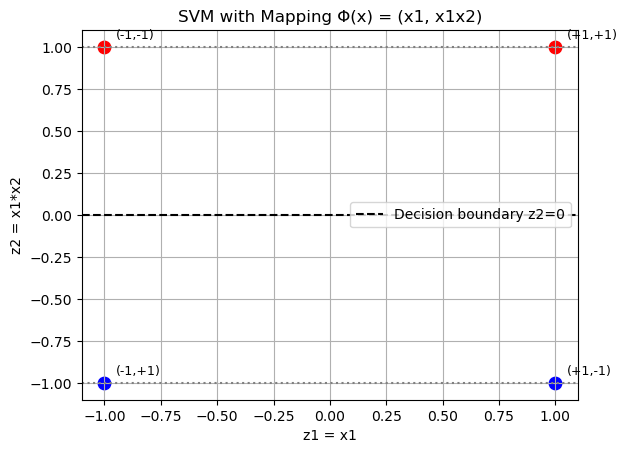

'\nMaximal marginal seperator is z2=0\nThe margin is 1\n\n'

In [3]:

#Task 6
import matplotlib.pyplot as plt


points = {
    '(-1,-1)': (-1, +1, 'red', '−'),
    '(-1,+1)': (-1, -1, 'blue', '+'),
    '(+1,-1)': (+1, -1, 'blue', '+'),
    '(+1,+1)': (+1, +1, 'red', '−'),
}

for label, (x, y, c, t) in points.items():
    plt.scatter(x, y, color=c, s=80)
    plt.text(x+0.05, y+0.05, label, fontsize=9)

plt.axhline(0, color='black', linestyle='--', label='Decision boundary z2=0')
plt.axhline(1, color='gray', linestyle=':')
plt.axhline(-1, color='gray', linestyle=':')
plt.xlabel("z1 = x1")
plt.ylabel("z2 = x1*x2")
plt.legend()
plt.title("SVM with Mapping Φ(x) = (x1, x1x2)")
plt.grid(True)
plt.show()


#Answer ----------
'''
Maximal marginal seperator is z2=0
The margin is 1

'''